# 1. Entendimento do Dataset
O arquivo JSON monster_cache.json é um dicionário onde cada chave é o ID do monstro (string) e o valor é outro dicionário com atributos, como:

- id: inteiro (id numérico do monstro)

- name: string (nome do monstro)

- level: inteiro (nível do monstro)

- race: string (raça do monstro)

- type: string (elemento do monstro, ex: fire, water)

- maps: lista de mapas onde o monstro aparece, com quantidade

- elementalDamage: dicionário com resistência/efeito dos elementos

- drops: lista de strings com nomes dos itens que o monstro dropa

---
# 2. Construção do Grafo (Rede)
Definição dos nós e arestas
Nós: Cada monstro é um nó, identificado pelo id.

Arestas: Duas arestas direcionadas entre monstros A e B são criadas se eles compartilham ao menos um item de drop, com peso igual ao número de itens em comum.

In [ ]:
import json
import networkx as nx

with open("monster_cache.json") as f:
    data = json.load(f)

G = nx.DiGraph()

# Adiciona nós com atributos
for mob_id, mob in data.items():
    G.add_node(mob['id'],
               name=mob['name'],
               level=mob['level'],
               race=mob.get('race', None),
               type=mob['type'])

# Adiciona arestas baseadas em drops em comum
mob_ids = list(data.keys())
for i, id_i in enumerate(mob_ids):
    drops_i = set(data[id_i]['drops'])
    for j in range(i + 1, len(mob_ids)):
        id_j = mob_ids[j]
        drops_j = set(data[id_j]['drops'])
        intersec = drops_i & drops_j
        if intersec:
            G.add_edge(data[id_i]['id'], data[id_j]['id'], weight=len(intersec))
            G.add_edge(data[id_j]['id'], data[id_i]['id'], weight=len(intersec))

---
# 3. Filtragem e Subgrafos

Como nem sempre a rede inteira está fortemente conectada, extraímos o maior subgrafo fortemente conectado para análises que exigem conectividade (ex: cálculo de diâmetro, centralidades que dependem de caminhos).

In [ ]:
if not nx.is_strongly_connected(G):
    componentes = sorted(nx.strongly_connected_components(G), key=len, reverse=True)
    maior_comp = componentes[0]
    Gc = G.subgraph(maior_comp).copy()
else:
    Gc = G

---
# 4. Métricas Estruturais Básicas

Densidade: Quantidade de arestas existentes dividido pelo total possível.

Assortatividade: Se nós tendem a se conectar a nós com grau similar (valor entre -1 e 1).

Diâmetro: Maior distância entre pares de nós na rede.

Periferia: Nós na maior distância (extremidades da rede).

In [ ]:
densidade = nx.density(Gc)
assort = nx.degree_assortativity_coefficient(Gc)
diametro = nx.diameter(Gc)
periferia = nx.periphery(Gc)

---
# 5. Distribuição de Grau e Clustering

Grafo real normalmente tem distribuição de grau heterogênea (poucos nós com alto grau, muitos com baixo grau) indicando característica Power Law.

Clustering local: mede densidade de conexões entre vizinhos do nó.

Clustering global: média dos clustering locais.

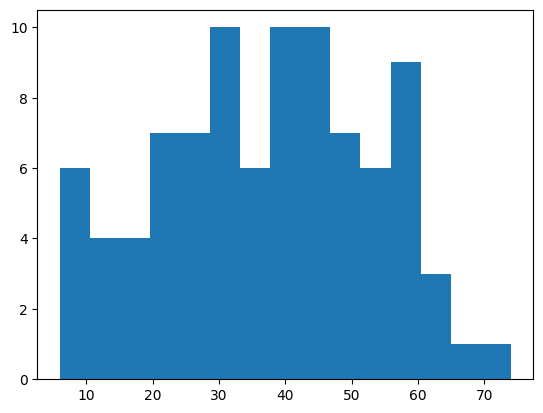

In [ ]:
graus = [d for _, d in Gc.degree()]
plt.hist(graus, bins=15)

clustering_local = nx.clustering(Gc.to_undirected())
clustering_global = nx.average_clustering(Gc.to_undirected())

---
# 6. Centralidades (Analise do Codigo Abaixo)

🔹Degree Centrality (Centralidade de Grau)

```Mede quantas conexões diretas um nó tem.```

Mais conectados: muka, soldier_skeleton, archer_skeleton, ghoul, argos.

Interpretação: esses monstros aparecem com frequência em conexões com muitos outros monstros — provavelmente são comuns em drops, mapas ou relações com outros monstros.

Exemplo: muka com 0.82 tem ligação com 82% dos nós possíveis. Ele é um hub da rede.

---

🔹 Closeness Centrality (Centralidade de Proximidade)
```Mede quão perto um nó está de todos os outros (eficiência de acesso a outros nós).```

Mais centrais: soldier_skeleton, ghoul, argos, muka.

Interpretação: esses monstros estão estrategicamente bem posicionados na rede — podem ser alcançados com poucos passos, indicando acesso rápido a muitas partes da rede.

---

🔹 Betweenness Centrality (Centralidade de Intermediação)
```Mede quantas vezes um nó aparece nos caminhos mais curtos entre outros nós.```

Mais intermediários: shining_plant, ghoul, swordfish, soldier_skeleton.

Interpretação: esses monstros controlam o fluxo de informação na rede — funcionam como pontes entre grupos diferentes.

Exemplo: shining_plant pode não ser o mais conectado, mas está no meio de muitos caminhos importantes.

---

🔹 Eigenvector Centrality (Centralidade de Autovalor)
```Mede a influência de um nó, considerando se ele está ligado a outros nós influentes.```

Mais influentes: muka, soldier_skeleton, archer_skeleton, female_thief_bug, thief_bug.

Interpretação: esses nós estão bem conectados a outros nós também importantes.

Exemplo: muka aparece novamente no topo — indicando que ele está no centro de uma região muito relevante da rede.

---

In [ ]:
degree = nx.degree_centrality(Gc)
closeness = nx.closeness_centrality(Gc)
betweenness = nx.betweenness_centrality(Gc)
eigen = nx.eigenvector_centrality(Gc)

import pandas as pd

# Criar DataFrame com todas as centralidades
central_df = pd.DataFrame({
    "id": list(degree.keys()),
    "Degree": list(degree.values()),
    "Closeness": list(closeness.values()),
    "Betweenness": list(betweenness.values()),
    "Eigenvector": list(eigen.values()),
})

# Adiciona nome do monstro usando atributos do grafo
central_df["Name"] = central_df["id"].apply(lambda x: Gc.nodes[x]['name'])

# Top 10 por Degree Centrality
print("\n🔹 Top 10 nós por Degree Centrality:")
print(central_df.sort_values(by="Degree", ascending=False).head(10)[["id", "Name", "Degree"]])

# Top 10 por Closeness Centrality
print("\n🔹 Top 10 nós por Closeness Centrality:")
print(central_df.sort_values(by="Closeness", ascending=False).head(10)[["id", "Name", "Closeness"]])

# Top 10 por Betweenness Centrality
print("\n🔹 Top 10 nós por Betweenness Centrality:")
print(central_df.sort_values(by="Betweenness", ascending=False).head(10)[["id", "Name", "Betweenness"]])

# Top 10 por Eigenvector Centrality
print("\n🔹 Top 10 nós por Eigenvector Centrality:")
print(central_df.sort_values(by="Eigenvector", ascending=False).head(10)[["id", "Name", "Eigenvector"]])





🔹 Top 10 nós por Degree Centrality:
      id              Name    Degree
46  1055              muka  0.822222
20  1028  soldier_skeleton  0.733333
13  1016   archer_skeleton  0.711111
28  1036             ghoul  0.688889
90  1100             argos  0.688889
60  1069         swordfish  0.666667
44  1053  female_thief_bug  0.644444
85  1095             andre  0.644444
23  1031          poporing  0.622222
15  1019         peco_peco  0.622222

🔹 Top 10 nós por Closeness Centrality:
      id              Name  Closeness
20  1028  soldier_skeleton   0.604027
28  1036             ghoul   0.604027
90  1100             argos   0.600000
46  1055              muka   0.596026
13  1016   archer_skeleton   0.588235
89  1099           argiope   0.576923
60  1069         swordfish   0.573248
0   1001          scorpion   0.573248
15  1019         peco_peco   0.569620
73  1083     shining_plant   0.569620

🔹 Top 10 nós por Betweenness Centrality:
      id              Name  Betweenness
73  1083     shi

---
# 7. Detecção de Comunidades (Louvain)

Método Louvain busca particionar a rede em grupos com mais conexões internas do que externas.

Tamanho das comunidades detectadas:
4    21
3    19
5    14
6    12
0    12
1     9
2     4
Name: count, dtype: int64


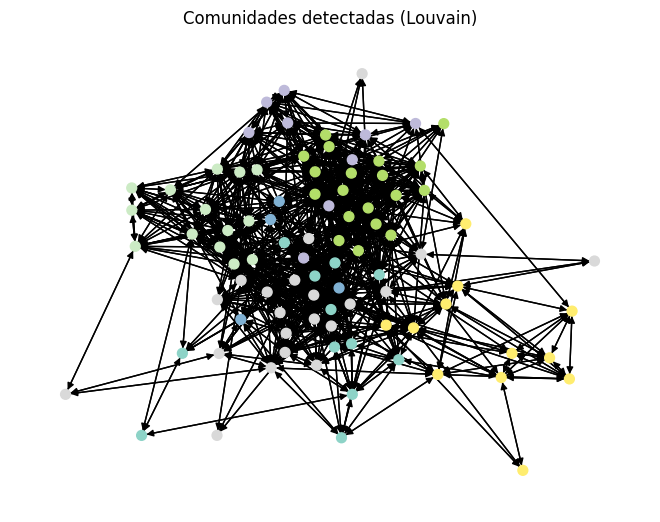

In [ ]:
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import pandas as pd

particoes = community_louvain.best_partition(Gc.to_undirected())
nx.set_node_attributes(Gc, particoes, 'comunidade')
comunidades = pd.Series(particoes).value_counts()

print("Tamanho das comunidades detectadas:")
print(comunidades)

pos = nx.spring_layout(Gc)
cores = [particoes[n] for n in Gc.nodes()]
nx.draw(Gc, pos, node_color=cores, with_labels=False, node_size=50, cmap=plt.cm.Set3)
plt.title("Comunidades detectadas (Louvain)")
plt.show()

---
# 9. Comparação com Redes Modelo

In [ ]:
def comparar_redes(rede, nome=""):
    G = rede.to_undirected()
    return {
        "Nome": nome,
        "Nº Nós": G.number_of_nodes(),
        "Nº Arestas": G.number_of_edges(),
        "Grau médio": sum(dict(G.degree()).values()) / G.number_of_nodes(),
        "Diâmetro": nx.diameter(G) if nx.is_connected(G) else "Desconexa",
        "Clusterização média": nx.average_clustering(G),
        "Caminho médio": nx.average_shortest_path_length(G) if nx.is_connected(G) else "Desconexa"
    }

resumo = pd.DataFrame([
    comparar_redes(Gc, "Rede Real"),
    comparar_redes(ER, "Erdős-Rényi"),
    comparar_redes(SW, "Small-World"),
    comparar_redes(BA, "Barabási-Albert"),
])

print(resumo)




              Nome  Nº Nós  Nº Arestas  Grau médio  Diâmetro  \
0        Rede Real      91         843   18.527473         4   
1      Erdős-Rényi      91         804   17.670330         3   
2      Small-World      91         182    4.000000         8   
3  Barabási-Albert      91         178    3.912088         5   

   Clusterização média  Caminho médio  
0             0.525725       1.949451  
1             0.200516       1.829792  
2             0.341026       4.395116  
3             0.179803       2.752381  


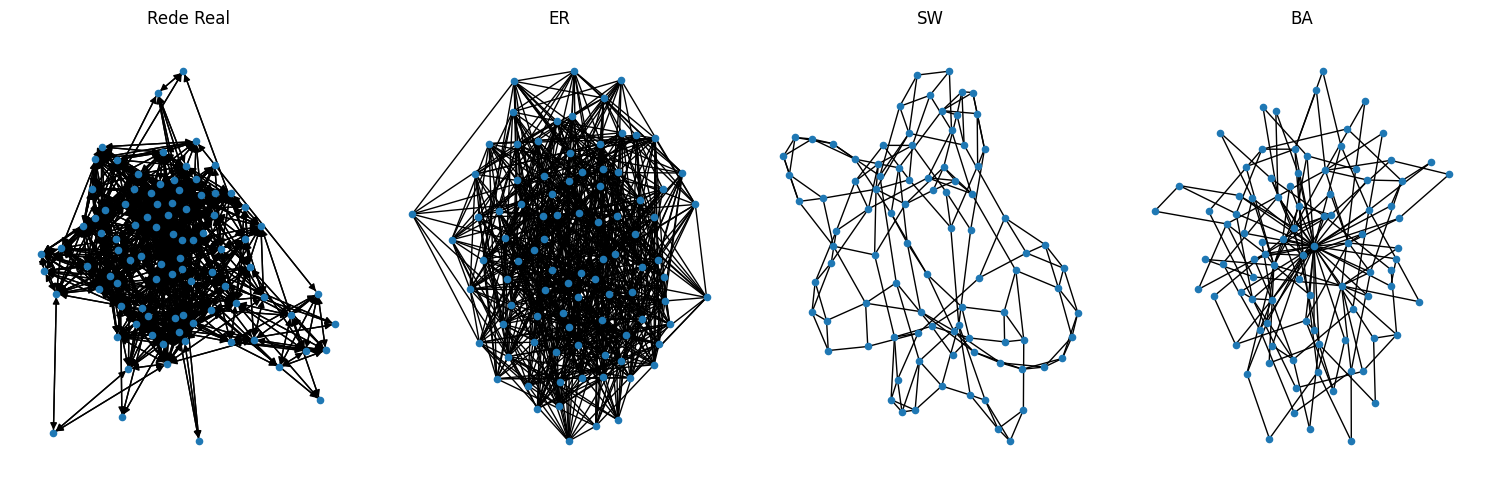

In [ ]:
n = Gc.number_of_nodes()
m = Gc.number_of_edges()

ER = nx.erdos_renyi_graph(n, p=m/(n*(n-1)))
SW = nx.watts_strogatz_graph(n, k=4, p=0.1)
BA = nx.barabasi_albert_graph(n, m=2)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

for i, (rede, titulo) in enumerate(zip([Gc, ER, SW, BA], ["Rede Real", "ER", "SW", "BA"])):
    plt.subplot(1, 4, i+1)
    nx.draw_spring(rede, node_size=20, with_labels=False)
    plt.title(titulo)

plt.tight_layout()
plt.show()


### Análise Crítica por Métrica

🔹 **Grau Médio**

A Rede Real tem grau médio bem mais alto que as outras: os nós são muito mais conectados, sugerindo interações densas (ex: muitos monstros dropam itens parecidos ou estão nos mesmos mapas).

Redes BA e SW têm graus médios mais baixos, pois foram geradas com poucos links por nó (k=4, m=2).

---

🔹 **Diâmetro**

O diâmetro (maior distância entre dois nós) é pequeno nas redes aleatórias (3 na ER), mas maior no Small-World (8), típico desse tipo de rede.

A Rede Real tem diâmetro 4, mostrando que é compacta — não há nós muito "distantes".

---

🔹 **Clusterização Média**

A Rede Real tem clusterização 0.53, bem maior que nas outras — ou seja, há comunidades bem definidas (ex: monstros relacionados por mapa ou tipo).

Small-World também é razoável nesse aspecto (0.34), já que esse modelo simula redes com agrupamentos.

ER e BA têm baixa clusterização (esperado).

---

🔹 **Caminho Médio**

Caminho médio pequeno na Rede Real (1.95) indica que os nós são muito próximos entre si.

Small-World tem o maior caminho médio (4.40), o que condiz com seu alto diâmetro.

BA e ER também têm valores baixos, típicos de redes com hubs ou conexões aleatórias.

---
# 10. Resiliência da Rede

**Teste remoção de nós**:

Remoção aleatória: simula falhas.

Remoção dirigida (hubs): simula ataques.

Monitore métricas como diâmetro e tamanho da maior componente conexa.

In [ ]:
import random

def diametro_apos_remocao(G, frac_remocao, modo='aleatorio'):
    Gc = G.copy()
    n_remover = int(frac_remocao * Gc.number_of_nodes())
    if modo == 'aleatorio':
        remover = random.sample(list(Gc.nodes()), n_remover)
    elif modo == 'degree':
        remover = sorted(Gc.degree(), key=lambda x: x[1], reverse=True)
        remover = [n for n, _ in remover[:n_remover]]
    else:
        return None

    Gc.remove_nodes_from(remover)
    try:
        return nx.diameter(Gc)
    except:
        return None

print(diametro_apos_remocao(Gc, 0.1, 'aleatorio'))
print(diametro_apos_remocao(Gc, 0.1, 'degree'))

4
4


O diâmetro da rede (maior distância mínima entre pares de nós) permaneceu em 4 após a remoção.

Ou seja, mesmo removendo 10% dos nós, seja de forma aleatória ou removendo os mais conectados, a rede continua com o mesmo diâmetro.

---
# 11. Link Prediction

Algoritmos como Resource Allocation, Jaccard Coefficient, Adamic-Adar podem sugerir conexões faltantes.

In [ ]:
from networkx.algorithms.link_prediction import resource_allocation_index

preds = resource_allocation_index(Gc.to_undirected())
top_preds = sorted(preds, key=lambda x: x[2], reverse=True)[:10]
for u, v, score in top_preds:
    print(f"Predição de link: {u} -- {v} (score: {score:.4f})")


Predição de link: 1031 -- 1051 (score: 0.6297)
Predição de link: 1031 -- 1047 (score: 0.6077)
Predição de link: 1053 -- 1002 (score: 0.5560)
Predição de link: 1047 -- 1095 (score: 0.5526)
Predição de link: 1031 -- 1076 (score: 0.5414)
Predição de link: 1024 -- 1036 (score: 0.5223)
Predição de link: 1031 -- 1011 (score: 0.5087)
Predição de link: 1035 -- 1083 (score: 0.4996)
Predição de link: 1031 -- 1093 (score: 0.4959)
Predição de link: 1035 -- 1100 (score: 0.4929)


Par 1031 -- 1051 com score 0.6297:
Indica que os monstros com IDs 1031 e 1051 têm uma alta probabilidade de ter alguma relação que ainda não foi capturada (ex: drops em comum, estar no mesmo mapa, ou características similares).

Par 1031 aparece muito (com 1051, 1047, 1076, 1011, 1093):
Esse monstro é um "hub" para potenciais novas conexões — talvez um monstro central em diferentes grupos.

Scores acima de 0.5 são geralmente considerados significativos.